In [1]:
import numpy as np
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
import os.path

%matplotlib inline  
import matplotlib.pyplot as plt

import utils
import keras
from math import log
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling1D,GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
size=(299,299)
base_model=keras.applications.xception.Xception(include_top=False,
                                          weights='imagenet',
                                          input_shape=list(size)+[3])
prepro=keras.applications.xception.preprocess_input
base_model.summary()

feat=GlobalAveragePooling2D()(base_model.output)
base_model=Model(inputs=base_model.input,outputs=feat)
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [3]:
datagen=image.ImageDataGenerator(preprocessing_function=prepro)
train_batches=datagen.flow_from_directory('train',target_size=size,batch_size=20,shuffle=False)
mini_batches=datagen.flow_from_directory('mini',target_size=size,batch_size=20,shuffle=False)
valid_batches=datagen.flow_from_directory('valid',target_size=size,batch_size=20,shuffle=False)
test_batches=datagen.flow_from_directory('test',target_size=size,batch_size=20,shuffle=False)

Found 23000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [4]:
x=base_model.output
x=Dense(32, activation='relu')(x)
x=Dropout(0.5)(x)
x=Dense(2, activation='softmax')(x)
predictions=x

for layer in base_model.layers:
    layer.trainable = False

model=Model(inputs=base_model.input,outputs=predictions)
model.summary()
model.compile(optimizer=Adam(1e-3),loss='categorical_crossentropy',metrics=["accuracy"])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [22]:
eps=0.01
inp=Input(shape=(2048,))
x=Dense(32, activation='relu')(inp)
x=Dropout(0.5)(x)
x=Dense(2, activation='softmax')(x)
x=Lambda(lambda act: keras.backend.clip(act,eps,1-eps))(x)
predictions=x

ll_model=Model(inputs=inp,outputs=predictions)
ll_model.summary()
ll_model.compile(optimizer=Adam(1e-3),loss='categorical_crossentropy',metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                65568     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 66        
_________________________________________________________________
lambda_3 (Lambda)            (None, 2)                 0         
Total params: 65,634
Trainable params: 65,634
Non-trainable params: 0
_________________________________________________________________


In [6]:
def get_ll(base_model, batches):
    ll=base_model.predict_generator(batches,steps=batches.n/batches.batch_size)
    classes=keras.backend.get_value(keras.backend.one_hot(batches.classes, batches.num_class))
    return ll,classes

In [7]:
train_ll = None
mini_ll = None
valid_ll = None

In [8]:
#preprocess validation data
train_ll = None
mini_ll = None
valid_ll = None
#valid_data=utils.get_data('valid',gen=datagen)
#valid_classes=keras.backend.get_value(keras.backend.one_hot(valid_batches.classes, valid_batches.num_class))

#train_ll=base_model.predict_generator(train_batches,steps=(train_batches.n/train_batches.batch_size)/8)
#train_classes=keras.backend.get_value(keras.backend.one_hot(train_batches.classes, train_batches.num_class))

train_ll,train_classes=get_ll(base_model,train_batches)
#mini_ll,mini_classes=get_ll(base_model,mini_batches)

valid_ll,valid_classes=get_ll(base_model,valid_batches)


In [27]:
for i in (train_ll,train_classes[:2860],valid_ll,valid_classes):
    print(i.shape)

AttributeError: 'NoneType' object has no attribute 'shape'

In [23]:
x,y=train_ll,train_classes
#model.layers[-2].rate=0.5 # dropout rate

ll_model.optimizer.lr=1e-3
ll_model.fit(x,y,
             validation_data=(valid_ll,valid_classes),
             batch_size=2**7,
             epochs=10)

ll_model.optimizer.lr=1e-5
ll_model.fit(x,y,
             validation_data=(valid_ll,valid_classes),
             batch_size=2**7,
             epochs=10)

ll_model.optimizer.lr=1e-7
ll_model.fit(x,y,
             validation_data=(valid_ll,valid_classes),
             batch_size=2**7,
             epochs=10)

Train on 23000 samples, validate on 2000 samples
Epoch 1/10
23000/23000 [==============================] - 1s - loss: 0.0571 - acc: 0.9848 - val_loss: 0.0250 - val_acc: 0.9960
Epoch 2/10
23000/23000 [==============================] - 1s - loss: 0.0294 - acc: 0.9944 - val_loss: 0.0266 - val_acc: 0.9940
Epoch 3/10
23000/23000 [==============================] - 1s - loss: 0.0266 - acc: 0.9951 - val_loss: 0.0259 - val_acc: 0.9940
Epoch 4/10
23000/23000 [==============================] - 1s - loss: 0.0249 - acc: 0.9957 - val_loss: 0.0236 - val_acc: 0.9950
Epoch 5/10
23000/23000 [==============================] - 1s - loss: 0.0239 - acc: 0.9953 - val_loss: 0.0242 - val_acc: 0.9945
Epoch 6/10
23000/23000 [==============================] - 1s - loss: 0.0216 - acc: 0.9962 - val_loss: 0.0237 - val_acc: 0.9950
Epoch 7/10
23000/23000 [==============================] - 1s - loss: 0.0203 - acc: 0.9967 - val_loss: 0.0246 - val_acc: 0.9940
Epoch 8/10
23000/23000 [==============================] - 1s -

In [39]:
ll_model.optimizer.lr=1e-7
ll_model.fit(x,y,
             validation_data=(valid_ll,valid_classes),
             batch_size=2**13,
             epochs=10)

Train on 1000 samples, validate on 2000 samples
Epoch 1/10
1000/1000 [==============================] - 1s - loss: 5.8255 - acc: 0.6290 - val_loss: 3.4856 - val_acc: 0.7735
Epoch 2/10
1000/1000 [==============================] - 1s - loss: 5.8246 - acc: 0.6320 - val_loss: 3.4822 - val_acc: 0.7745
Epoch 3/10
1000/1000 [==============================] - 1s - loss: 5.7907 - acc: 0.6330 - val_loss: 3.4808 - val_acc: 0.7740
Epoch 4/10
1000/1000 [==============================] - 1s - loss: 5.7431 - acc: 0.6400 - val_loss: 3.4873 - val_acc: 0.7710
Epoch 5/10
1000/1000 [==============================] - 1s - loss: 5.7071 - acc: 0.6410 - val_loss: 3.5018 - val_acc: 0.7695
Epoch 6/10
1000/1000 [==============================] - 1s - loss: 5.6931 - acc: 0.6410 - val_loss: 3.5183 - val_acc: 0.7670
Epoch 7/10
1000/1000 [==============================] - 1s - loss: 5.6787 - acc: 0.6420 - val_loss: 3.5339 - val_acc: 0.7675
Epoch 8/10
1000/1000 [==============================] - 1s - loss: 5.6645 - a

In [15]:
print("copying weights for layer:",model.layers[-1])
model.layers[-1].set_weights(ll_model.layers[-1].get_weights())
print("copying weights for layer:",model.layers[-3])
model.layers[-3].set_weights(ll_model.layers[-3].get_weights())

('copying weights for layer:', <keras.layers.core.Dense object at 0x7f28145bce90>)
('copying weights for layer:', <keras.layers.core.Dense object at 0x7f28145baf10>)


In [11]:
aug_datagen=image.ImageDataGenerator(preprocessing_function=prepro,
                                    rotation_range=15,
                                    width_shift_range=.1,
                                    height_shift_range=.1,
                                    zoom_range=.1,
                                    channel_shift_range=.1)
aug_train_batches=aug_datagen.flow_from_directory('train',target_size=size,batch_size=20)

model.optimizer.lr=1e-3
#model.layers[-2].rate=0.0 # dropout rate
model.fit_generator(aug_train_batches,
                    steps_per_epoch=aug_train_batches.n/aug_train_batches.batch_size,
                    validation_data=valid_batches,
                    validation_steps=valid_batches.n/valid_batches.batch_size,
                    workers=4,
                    epochs=5)

Found 23000 images belonging to 2 classes.
Epoch 1/5
1150/1150 [==============================] - 861s - loss: 0.5587 - acc: 0.9563 - val_loss: 0.2251 - val_acc: 0.9845
Epoch 2/5
  70/1150 [>.............................] - ETA: 735s - loss: 0.4633 - acc: 0.9664

KeyboardInterrupt: 

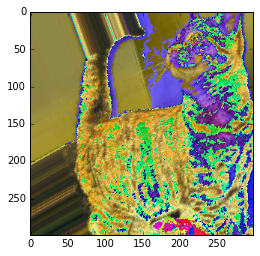

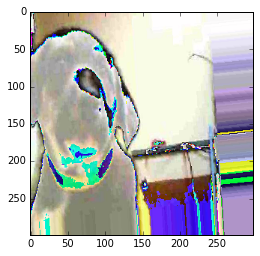

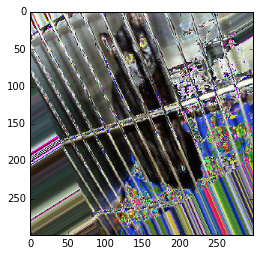

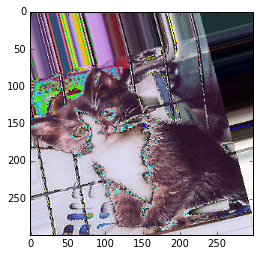

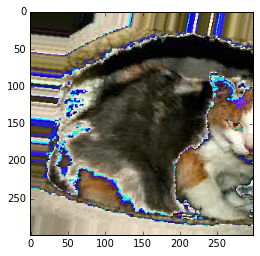

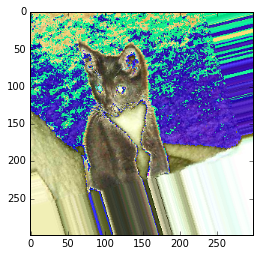

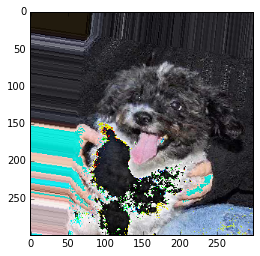

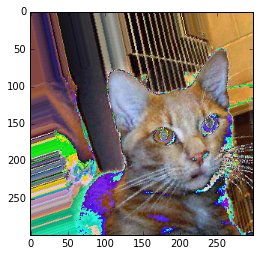

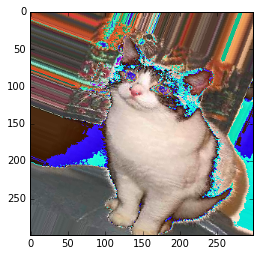

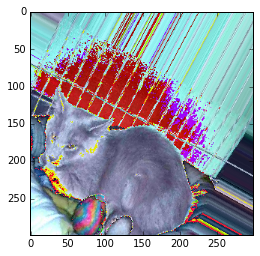

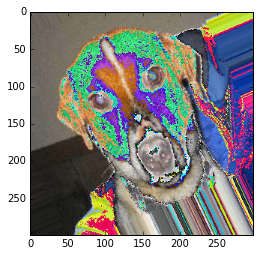

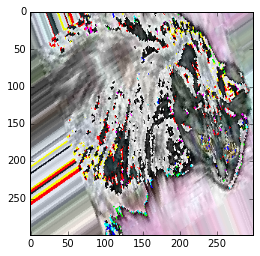

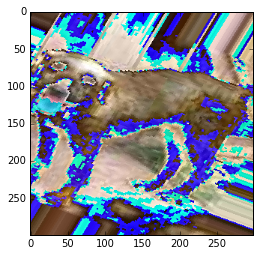

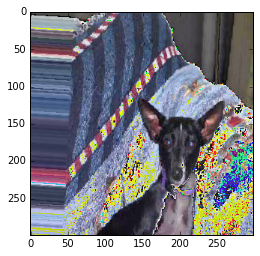

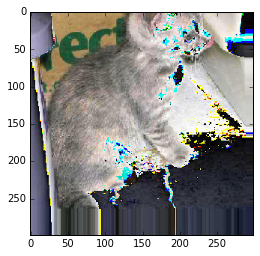

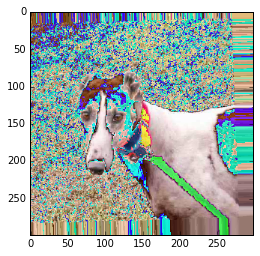

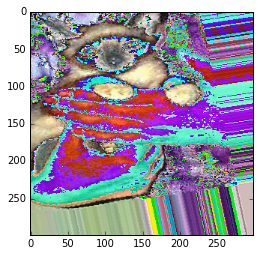

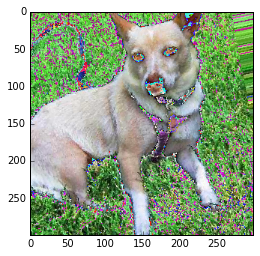

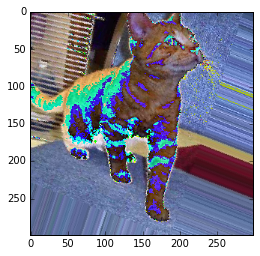

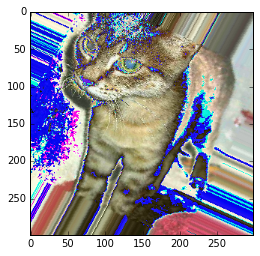

In [17]:
imgs,lbl=next(aug_train_batches)
for img in imgs:
    plt.figure()
    plt.imshow(img)

In [55]:
model.layers[-2].rate=0.0

In [19]:
model.layers[-2]

In [16]:
model.evaluate_generator(valid_batches,steps=valid_batches.n/valid_batches.batch_size)

[0.030758236116662941, 0.99549999892711638]

In [25]:
pred=model.predict_generator(test_batches,steps=test_batches.n/test_batches.batch_size)

KeyboardInterrupt: 

In [26]:
isdog=np.clip(pred[:,1],eps,1-eps)
ids=[ int(os.path.basename(f).split('.')[-2]) for f in test_batches.filenames]
sub=np.stack([ids,isdog],axis=1)
np.savetxt('trained2-lessclip.csv',sub,fmt='%d,%.5f',header='id,label',comments='')

In [127]:
model.layers.insert(1,Lambda(lambda x: prepro(x)))


In [128]:
print(model.layers[0])
print(model.layers[1])
model.compile(optimizer=Adam(1e-3),loss='categorical_crossentropy',metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________


RuntimeError: You tried to call `count_params` on lambda_2, but the layer isn't built. You can build it manually via: `lambda_2.build(batch_input_shape)`.